In [1]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import datetime

from scipy.spatial import distance
from scipy.signal import savgol_filter

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier 

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
import joblib

import seaborn as sns

## DataTransformation

In [33]:
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_bands.json", 'r') as f:
    train_data = json.load(f)
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_test_bands.json", 'r') as f:
    test_data = json.load(f)


In [3]:
def interpolate_linear(liste):
    # Boucle pour l'interpolation linéaire
    for i in range(len(liste)):
        if liste[i] is None:
            # Trouver les indices des valeurs non nulles les plus proches
            j = i - 1
            while liste[j] is None:
                j -= 1
            k = i + 1
            while k < len(liste) and liste[k] is None:
                k += 1
            # Calculer la valeur intermédiaire
            if j < 0:
                valeur_intermediaire = liste[k]
            elif k >= len(liste):
                valeur_intermediaire = liste[-1]
            else:
                valeur_intermediaire = liste[j] + (liste[k] - liste[j]) * (i - j) / (k - j)
            # Remplacer la valeur None par la valeur intermédiaire
            liste[i] = valeur_intermediaire
    
    none_indices = [i for i, liste in enumerate(liste) if liste is None]
    
    try : 
        last = none_indices[0]
        for i in range(last, len(liste)):
            liste[i] = liste[last-1]
    except IndexError:
        pass
    return liste

In [4]:
def correction(X):
    interpolated = interpolate_linear(X)
    polynomial_regression = savgol_filter(interpolated, window_length=11, polyorder=5, mode="nearest")
    max_poly = [max(interpolated[i], polynomial_regression[i]) for i in range(len(interpolated))]

    return max_poly

In [5]:
def month_fullbands(date, band):
    monthly = []
    
    for i in range(1, 13):
        datetimes = [datetime.datetime.fromtimestamp(t/1000) for t in date]
        is_first_half = [d.month == i and d.day <= 15 for d in datetimes] # bool list of first 15 days of month
        val = np.array([x for x, m in zip(band, is_first_half) if m and x is not None])
        
        if len(val) > 0 :
            monthly.append(val.sum() / len(val))
        else :
            monthly.append(None)

        
        is_second_half = [d.month == i and d.day > 15 for d in datetimes] # bool list of last 15 days of month
        val = np.array([x for x, m in zip(band, is_second_half) if m and x is not None])
        
        if len(val) > 0 :
            monthly.append(val.sum() / len(val))
        else :
            monthly.append(None)
        
    return correction(monthly)


In [162]:
def normalize_parcelles(parcelles):
    X = []
    X_flat = []
    y = []
    c = []
    for i in range(len(parcelles)):
        try :
            y.append(parcelles[str(i)]['code_group'])

            if parcelles[str(i)]['code_group'] in [1,2,3,5,6,7]:
                c.append(parcelles[str(i)]['code_group'])
            elif parcelles[str(i)]['code_group'] in [4,9,14]:
                c.append(0)
            elif parcelles[str(i)]['code_group'] in [15, 8]:
                c.append(4)
            elif parcelles[str(i)]['code_group'] in [16, 17, 18, 19]:
                c.append(8)
            elif parcelles[str(i)]['code_group'] in [20, 21, 22, 23]:
                c.append(9)
            elif parcelles[str(i)]['code_group'] in [24, 25]:
                c.append(10)
                
            parcel = parcelles[str(i)]['data']
            arrays = np.array([value for keys, value in parcel.items()])
            
            indices = np.where(arrays[1] == None)
            date = np.delete(arrays[0], indices)
    
            montly = []
            for j in range(1, 14):
                band = np.delete(arrays[j], indices)
                montly.append(month(date, band))
                
            X.append(np.transpose(np.array(montly)))
            X_flat.append(np.array(montly).flatten())
        except Exception:
            pass

    return X, X_flat, y, c

In [190]:
X_train, X_train_flat, y_train, c_train = normalize_parcelles(train_data)
X_test, X_test_flat, y_test, c_test = normalize_parcelles(test_data)

In [191]:
c_train_binary = to_categorical(c_train, num_classes=11)
c_test_binary = to_categorical(c_test, num_classes=11)

## Display 

In [141]:
def display_hist(history):
    fig, axs = plt.subplots(2, figsize=(10,12))
    #plot training history - accuracy
    axs[0].plot(history.history['accuracy'], label='train')
    axs[0].plot(history.history['val_accuracy'], label='validation')
    axs[0].set_title("Accuracy at each epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    
    #plot training history - loss function
    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].legend()
    axs[1].set_title("Loss at each epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("categorical_crossentropy")
    plt.show()

In [121]:
target_names = ['Autres céréales _ Plante à fibre _ Riz','Blé tendre','Maïs grain et ensilage','Orge','Protéagineux _ leguminause à grain',
                'Colza','Tournesol','Autres oléagineux',
                'Fourrage_Estives et landes_Prairies permanentes_Prairies temporaires','Vergers_Vignes_Fruits à coque_Oliviers',
                'Autres cultures industrielles_Légumes ou fleurs']

In [122]:
def plot_confusion_matrix_perso(cm, target_names, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    corr_mat_filtre = np.where(cm >= 0.05, cm, np.nan)
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_mat_filtre, annot=True, cmap="coolwarm", vmin=0.0, xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


## Dense

In [169]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [170]:
model_dense = tf.keras.Sequential([
    tf.keras.Input((312, )),
    Dense(312),
    Dense(156),
    Dropout(0.1),
    Dense(78),
    Dropout(0.1),
    Dense(39),
    Dense(11, activation=tf.nn.softmax)
])

model_dense.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 312)                 │          97,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 156)                 │          48,828 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 156)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 78)                  │          12,246 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 78)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 39)                  │           3,081 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 11)                  │             440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,251 (633.79 KB)

 Trainable params: 162,251 (633.79 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
model_dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = EarlyStopping(min_delta=1e-5, 
                         patience = 50, 
                         mode = "max", 
                         monitor = "val_accuracy", 
                         restore_best_weights=True)

In [175]:
history_dense = model_dense.fit(
    np.array(X_train_flat),
    np.array(c_train_binary),
    batch_size=512,
    epochs=300,
    validation_data=(np.array(X_test_flat), np.array(c_test_binary)),
    callbacks = [callback]
)

Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3052 - loss: 6297.0269 - val_accuracy: 0.6161 - val_loss: 718.5048
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5623 - loss: 798.0793 - val_accuracy: 0.7119 - val_loss: 259.0849
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6420 - loss: 341.3204 - val_accuracy: 0.7204 - val_loss: 187.6786
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6517 - loss: 265.4413 - val_accuracy: 0.7667 - val_loss: 132.2381
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6713 - loss: 225.4713 - val_accuracy: 0.7477 - val_loss: 140.5301
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6729 - loss: 198.6718 - val_accuracy: 0.7467 - val_loss: 121.1773
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6808 - loss: 185.8715 - val_accuracy: 0.7734 - val_loss: 129.8870
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7036 - lo

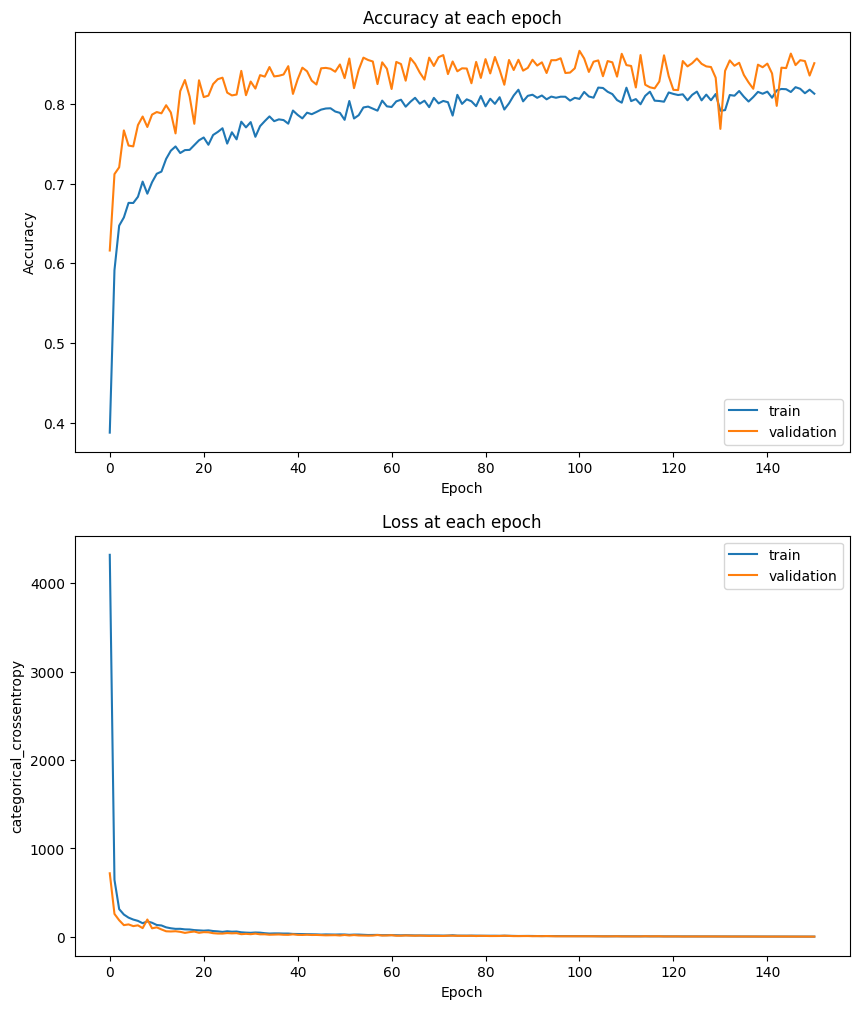

In [176]:
display_hist(history_dense)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


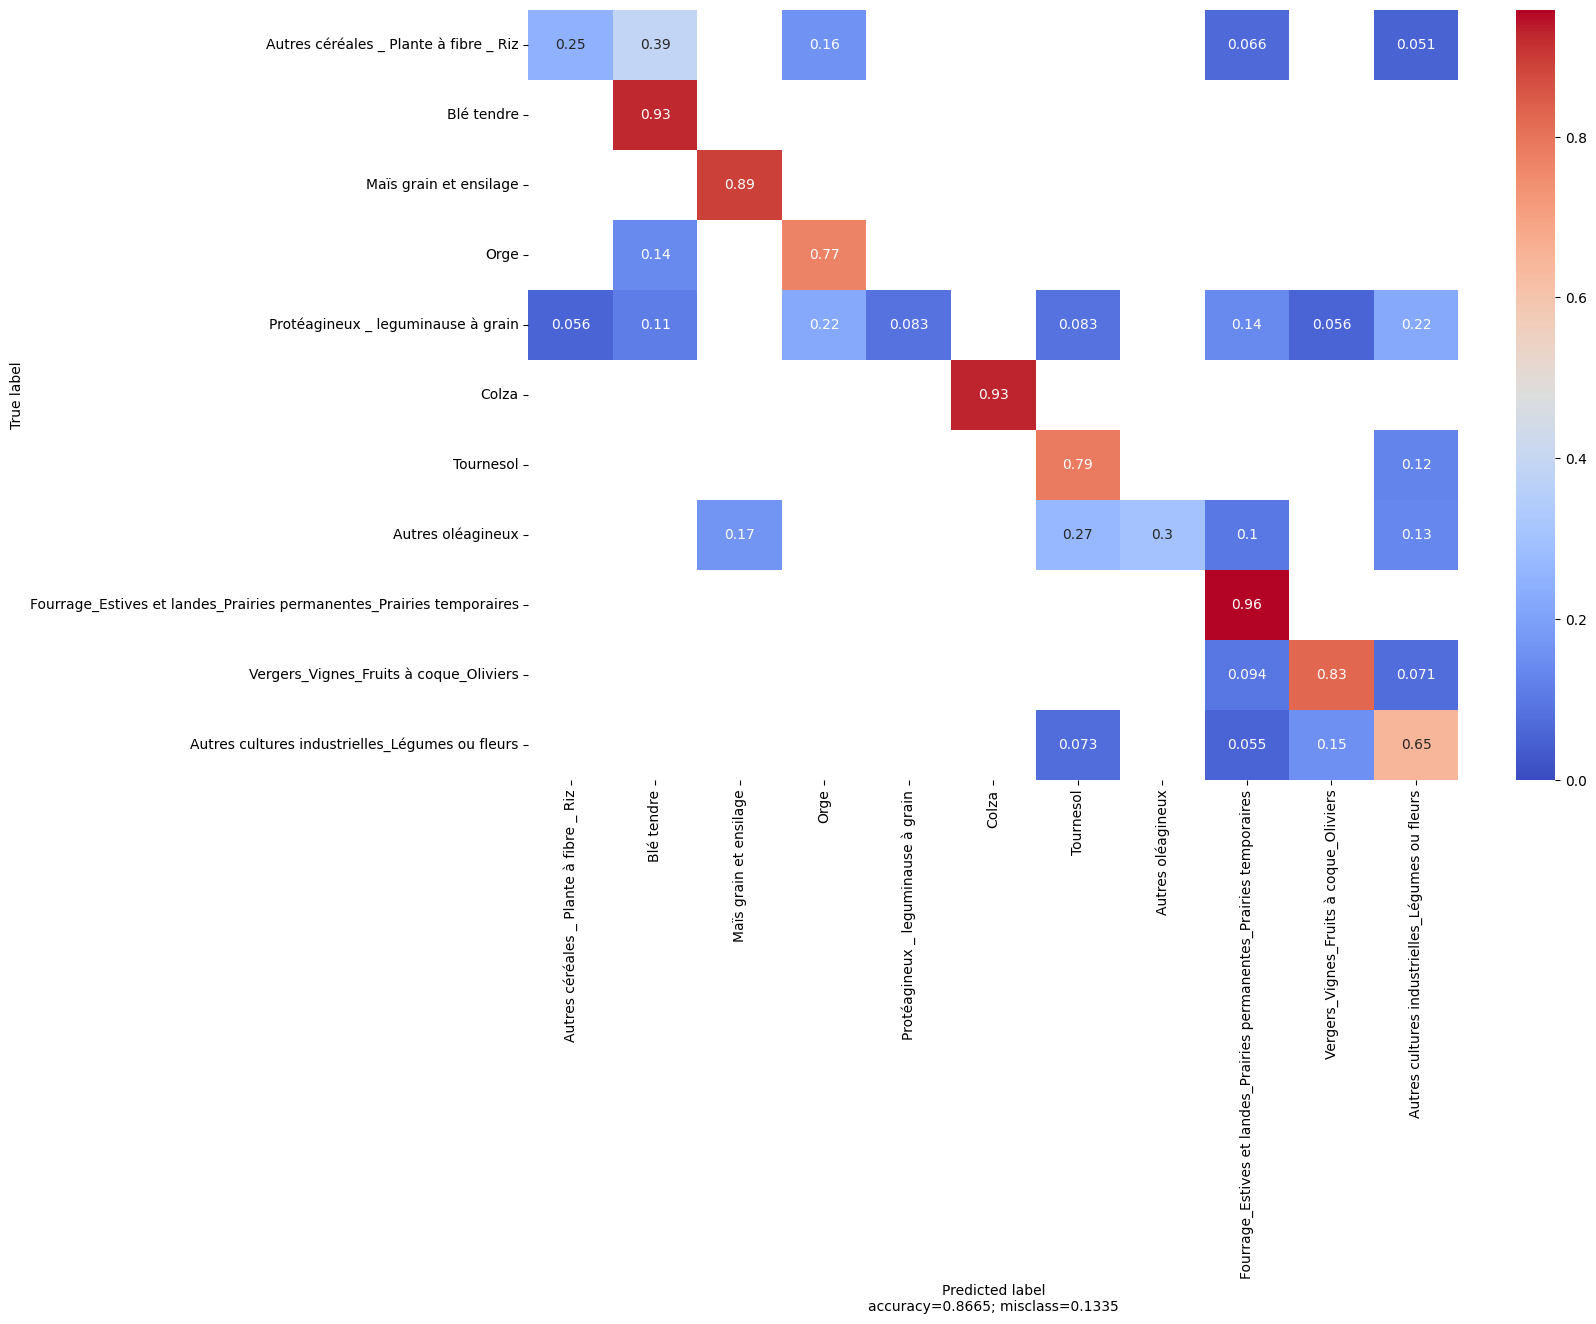

In [192]:
dense_prediction = np.argmax(model_dense.predict(np.array(X_test_flat)), axis=1) 
conf_matrix_dense = confusion_matrix(c_test, dense_prediction)
plot_confusion_matrix_perso(conf_matrix_dense, target_names, title='Confusion matrix')

## LSTM

In [124]:
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0 

In [205]:
model_lstm = tf.keras.Sequential([
    tf.keras.Input((24, 13)),
    LSTM(input_shape=(24, 13), units=13,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                         dropout=DP, recurrent_dropout=RDP,
                         return_sequences=True, return_state=False,
                         stateful=False, unroll=False
                        ),
    LSTM(input_shape=(24, 13), units=13,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                         dropout=DP, recurrent_dropout=RDP,
                         return_sequences=True, return_state=False,
                         stateful=False, unroll=False
                        ),
    tf.keras.layers.Flatten(),
    Dense(11, activation=tf.nn.softmax)
])

C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [206]:
# Compile the model with Adam optimizer
model_lstm.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(min_delta=1e-5, 
                           patience = 50, 
                           mode = "max", 
                           monitor = "val_accuracy", 
                           restore_best_weights=True)

model_lstm.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 24, 13)              │           1,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 24, 13)              │           1,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 312)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 11)                  │           3,443 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,251 (24.42 KB)

 Trainable params: 6,251 (24.42 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
lstm_history = model_lstm.fit(x=np.array(X_train),
                    y=np.array(c_train_binary),
                    batch_size=512,
                    epochs=300,
                    validation_split=0.0,
                    validation_data=(np.array(X_test), np.array(c_test_binary)),
                    shuffle=True,verbose=1,
                    callbacks=[early_stop])

Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3800 - loss: 3.9845 - val_accuracy: 0.5377 - val_loss: 3.0869
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4871 - loss: 3.0422 - val_accuracy: 0.5377 - val_loss: 2.6242
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5075 - loss: 2.5838 - val_accuracy: 0.5647 - val_loss: 2.2959
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5354 - loss: 2.2669 - val_accuracy: 0.5682 - val_loss: 2.0094
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5671 - loss: 1.9575 - val_accuracy: 0.5869 - val_loss: 1.7638
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5879 - loss: 1.7508 - val_accuracy: 0.6455 - val_loss: 1.5645
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6423 - loss: 1.5426 - val_accuracy: 0.6736 - val_loss: 1.4234
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6616 - loss: 1.4038 - val_accuracy: 0.

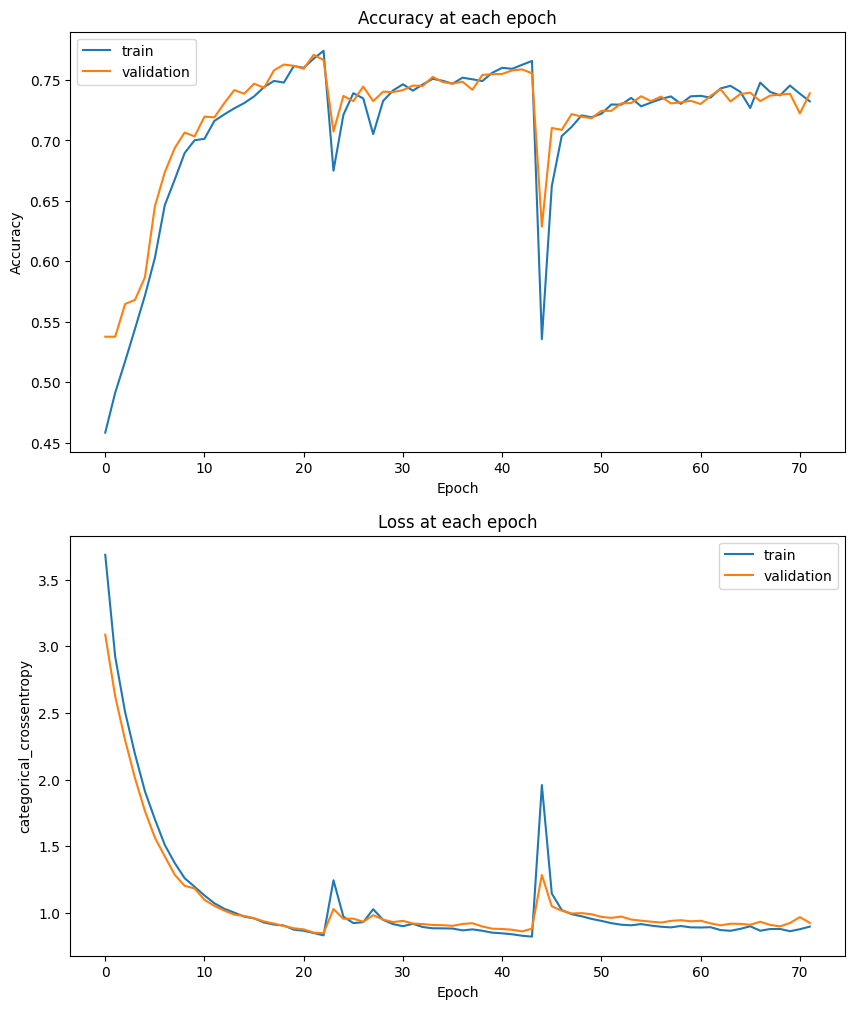

In [208]:
display_hist(lstm_history)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


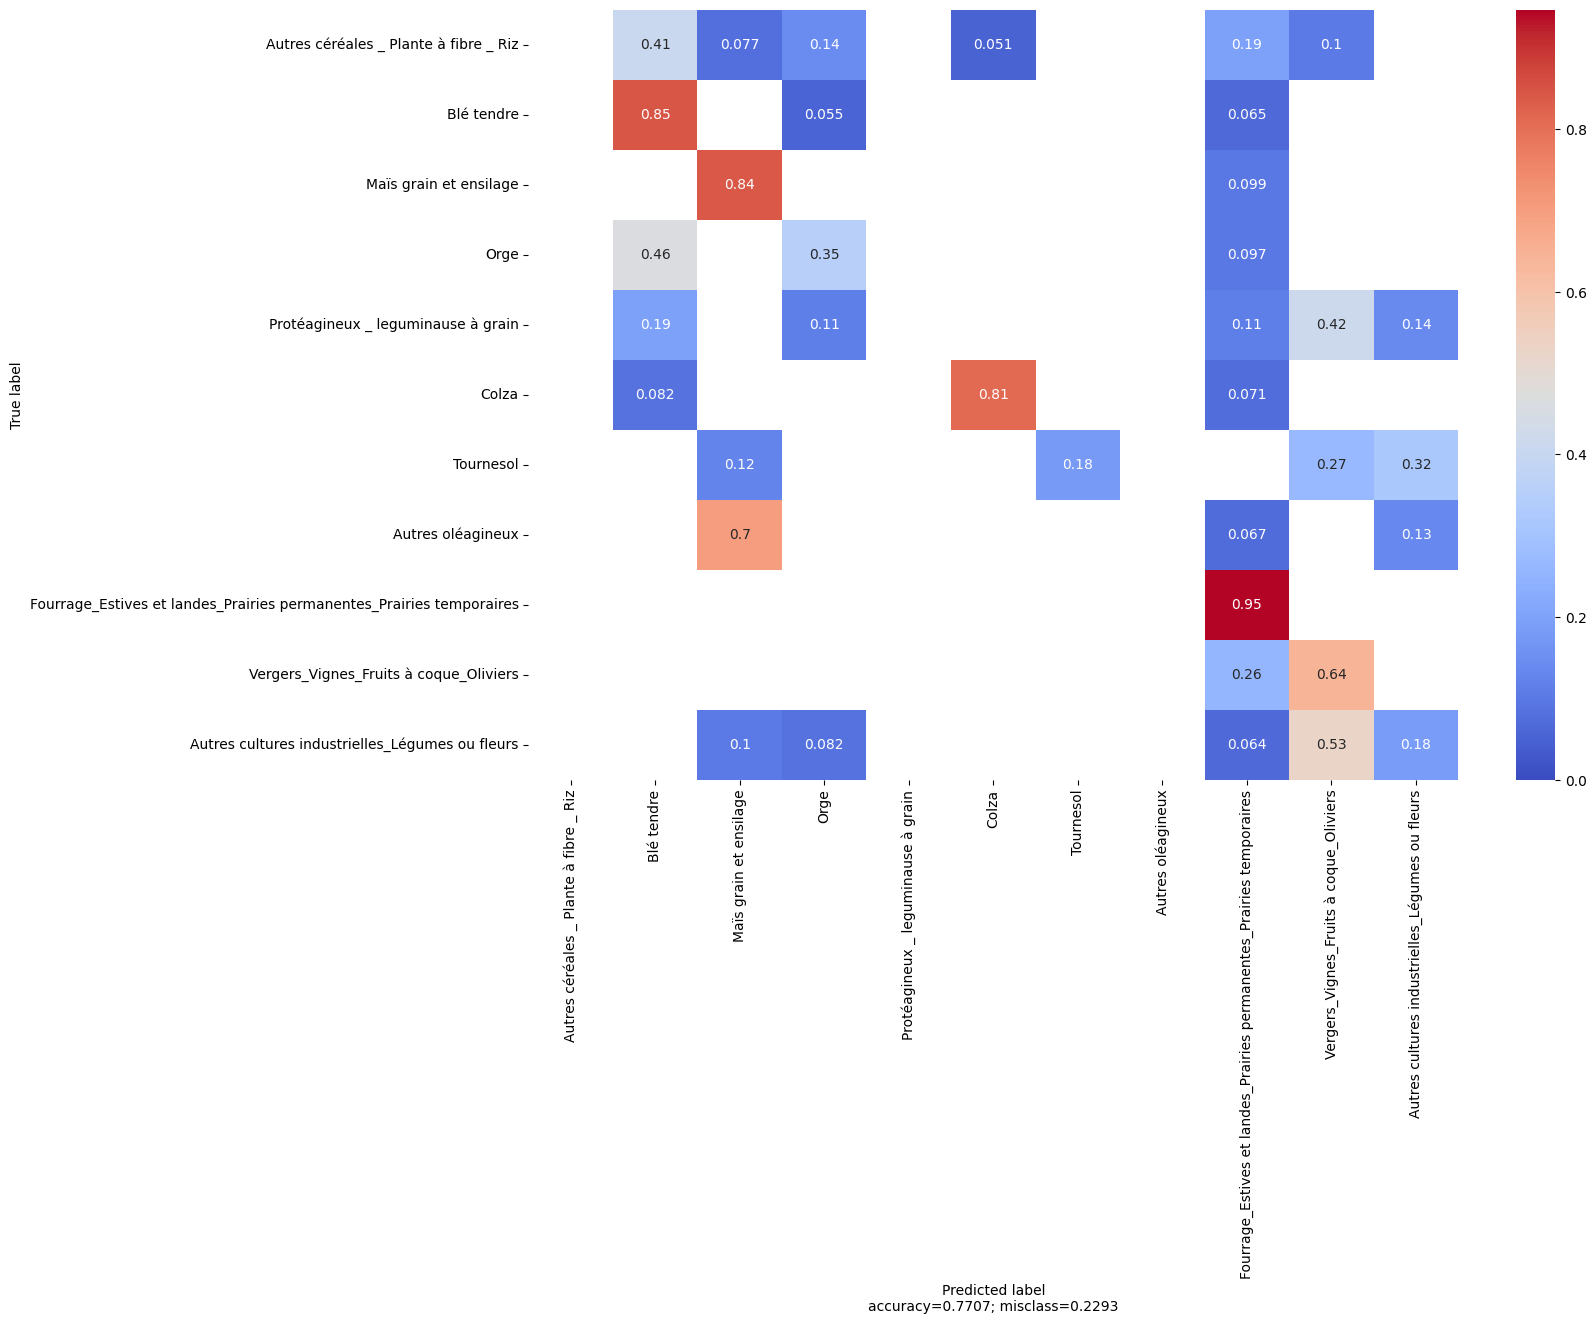

In [209]:
lstm_prediction = np.argmax(model_lstm.predict(np.array(X_test)), axis=1)
conf_matrix_lstm=confusion_matrix(c_test,lstm_prediction)
plot_confusion_matrix_perso(conf_matrix_lstm, target_names, title='Confusion matrix')

In [203]:
from sklearn.ensemble import RandomForestClassifier 
RFC = RandomForestClassifier()
RFC.fit(X_train_flat, c_train)

RandomForestClassifier()

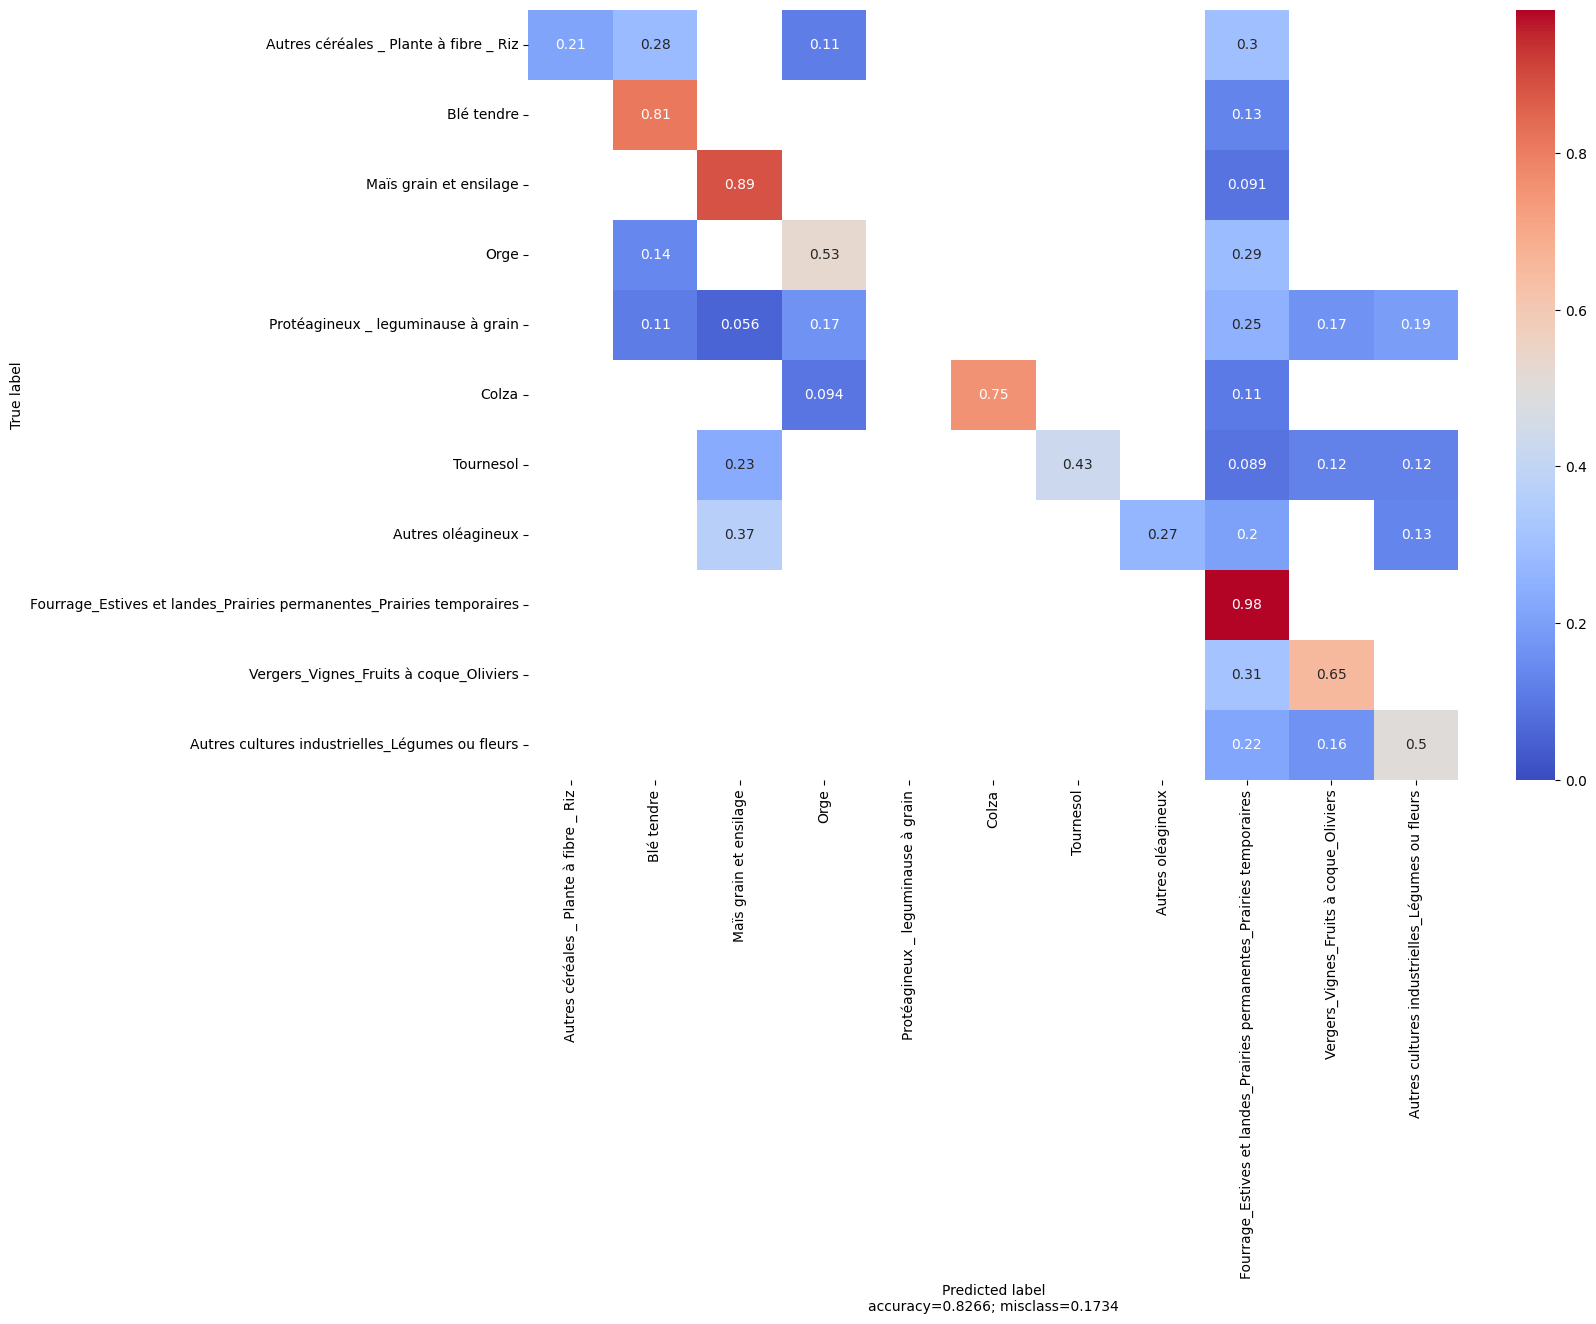

In [204]:
RFC_prediction = RFC.predict(X_test_flat)
conf_matrix_RFC = confusion_matrix(c_test, RFC_prediction)
plot_confusion_matrix_perso(conf_matrix_RFC, target_names, title='Confusion matrix')